In [13]:
import numpy as np
from get_coords import get_coords

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc

font = {'size'   : 20}
rc('font', **font)

# Building the functions - using just one domain 16pkA01

In [4]:
coords = get_coords('16pkA01')
coords

array([[5, 'GLU', 'E', ..., -15.953, 21.156, 16.122],
       [5, 'GLU', 'E', ..., -15.944, 19.956, 15.229],
       [5, 'GLU', 'E', ..., -16.724, 20.23, 13.94],
       ...,
       [192, 'LEU', 'L', ..., -6.902, 31.661, 16.767],
       [192, 'LEU', 'L', ..., -5.748, 32.421, 16.114],
       [192, 'LEU', 'L', ..., -7.745, 30.979, 15.701]], dtype=object)

## What are the distances between neigboring atoms? What about same atoms?
`C-N` `N-CA` `CA-C` `CA-CB`

`C--C` `CA--CA` `N--N`

In [11]:
v = np.array([list(i) for i in coords if i[3] in ['N', 'C']])
v

array([['5', 'GLU', 'E', ..., '-15.953', '21.156', '16.122'],
       ['5', 'GLU', 'E', ..., '-14.514', '19.536', '14.879'],
       ['6', 'LYS', 'K', ..., '-13.659', '20.505', '14.561'],
       ...,
       ['191', 'TYR', 'Y', ..., '-7.24', '30.063', '18.559'],
       ['192', 'LEU', 'L', ..., '-6.403', '30.676', '17.731'],
       ['192', 'LEU', 'L', ..., '-7.745', '30.979', '15.701']],
      dtype='<U21')

In [2]:
def compute_dist(coords, atom1, atom2):
    dist_vec = []
    
    # filter 
    c = np.array([list(i) for i in coords if i[3] in [atom1, atom2]])
    
    if atom1 == atom2:
        for i in range(len(c) - 1):
            if c[i + 1, 0].astype(np.int) - c[i, 0].astype(np.int) == 1:
                a1, a2 = c[i, 4:].astype(np.float), c[i + 1, 4:].astype(np.float)

                #if atom1 == 'CB' and c[i + 1, 0].astype(np.int) - c[i, 0].astype(np.int) > 1:
                #    pass
                #else:
                    #dist_vec.append(np.sqrt(sum((a1 - a2)**2)))
                dist_vec.append(np.sqrt(sum((a1 - a2)**2)))
    else:
        it = 0
        for i in range(len(c)//2 - 1):
            # I want the length of the bond between C-N, not their distance within residue
            if (atom1 == 'C' and atom2 == 'N') or (atom1 == 'N' and atom2 == 'C'):
                if c[it + 1, 0].astype(np.int) - c[it, 0].astype(np.int) == 1:
                    a1, a2 = c[it + 2, 4:].astype(np.float), c[it + 1, 4:].astype(np.float)
                    dist_vec.append(np.sqrt(sum((a1 - a2)**2)))
                    it += 2
                else:
                    it += 1
                    
            elif (atom1 == 'CA' and atom2 == 'CB') or (atom1 == 'CB' and atom2 == 'CA'):
                if c[it, 0] == c[it + 1, 0]:
                    a1, a2 = c[it, 4:].astype(np.float), c[it + 1, 4:].astype(np.float)
                    dist_vec.append(np.sqrt(sum((a1 - a2)**2)))
                    it += 2
                else:
                    it += 1
            else:
                if c[it + 1, 0].astype(np.int) - c[it, 0].astype(np.int) == 1:
                    a1, a2 = c[it, 4:].astype(np.float), c[it + 1, 4:].astype(np.float)
                    dist_vec.append(np.sqrt(sum((a1 - a2)**2)))
                    it += 2
                else:
                    it += 1
        
    return np.array(dist_vec)

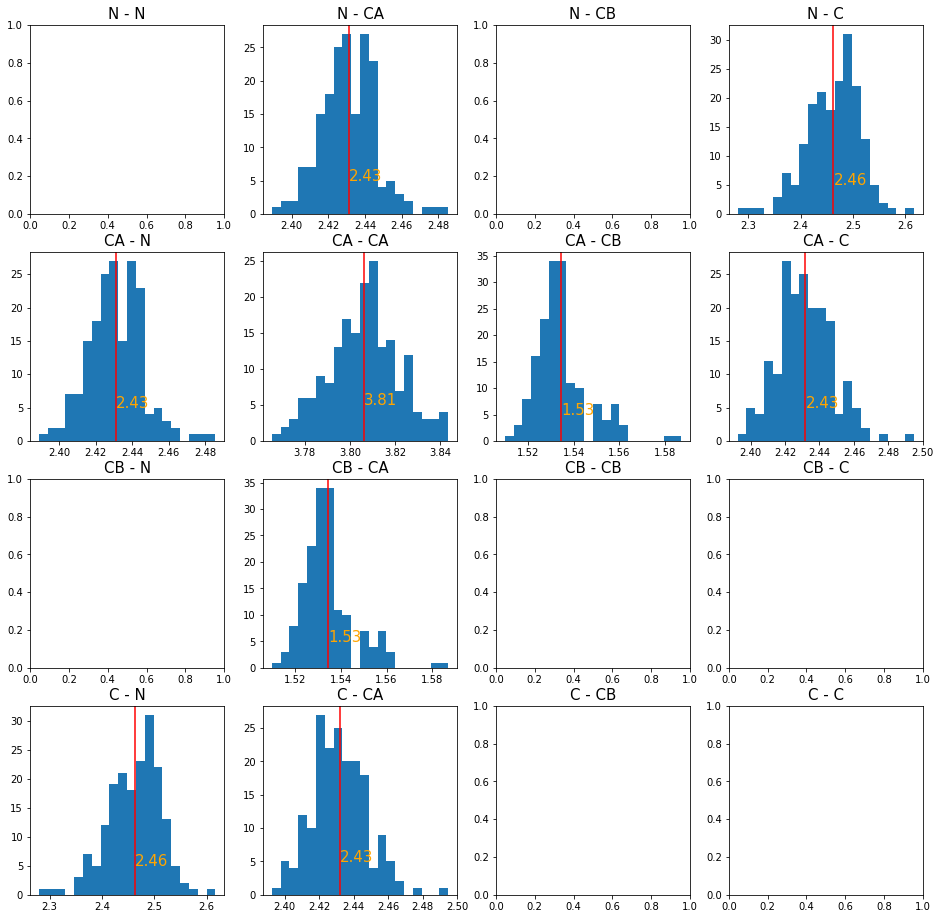

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

atoms = ['N', 'CA', 'CB', 'C']

for i in range(len(atoms)):
    for j in range(len(atoms)):
        if (atoms[i] == 'CB' and atoms[j] not in ['CA', 'CB']) or (atoms[j] == 'CB' and atoms[i] not in ['CA', 'CB']):
            ax[i, j].set_title(f'{atoms[i]} - {atoms[j]}', fontsize=15)
            
        elif atoms[i] == atoms[j] and atoms[i] != 'CA':
            ax[i, j].set_title(f'{atoms[i]} - {atoms[j]}', fontsize=15)
        else:
            dist = compute_dist(coords, atoms[i], atoms[j])
            ax[i, j].hist(dist, bins=20)
            ax[i, j].axvline(np.mean(dist), c='red')
            ax[i, j].text(np.mean(dist), 5, f'{round(np.mean(dist), 2)}', c='orange', fontsize=15)
            ax[i, j].set_title(f'{atoms[i]} - {atoms[j]}', fontsize=15)

## What are the angles (not torsion)?
`C-N-CA` `N-CA-C` `CA-C-N`

In [3]:
def compute_angles(coords, angle_atoms):
    angle_vec = []
    
    # filter
    if angle_atoms == ('C', 'CA', 'CB'):
        c = coords[coords[:, 2] != 'G']
        c = c[c[:, 3] != 'N']
        
        for i in range(len(c) - 3):
            if c[i, 3] == 'CA':
                if c[i, 0] == c[i+1, 0] == c[i+2, 0]:
                    a2, a3, a1 = c[i, 4:].astype(np.float), c[i+1, 4:].astype(np.float), c[i+2, 4:].astype(np.float)

                    v1, v2 = a2 - a1, a3 - a2            
                    v1_size, v2_size = np.sqrt(np.sum(v1**2)), np.sqrt(np.sum(v2**2))

                    angle = np.degrees(np.pi - np.arccos(np.sum(v1 * v2) / (v1_size * v2_size)))

                    angle_vec.append(angle)
        
    else:
        c = np.array([list(i) for i in coords if i[3] != 'CB'])
       
        for i in range(len(c) - 3):
            if c[i, 3] == angle_atoms[0]:
                a1, a2, a3 = c[i, 4:].astype(np.float), c[i+1, 4:].astype(np.float), c[i+2, 4:].astype(np.float)

                v1, v2 = a2 - a1, a3 - a2            
                v1_size, v2_size = np.sqrt(np.sum(v1**2)), np.sqrt(np.sum(v2**2))

                angle = np.degrees(np.pi - np.arccos(np.sum(v1 * v2) / (v1_size * v2_size)))

                angle_vec.append(angle)
    return angle_vec

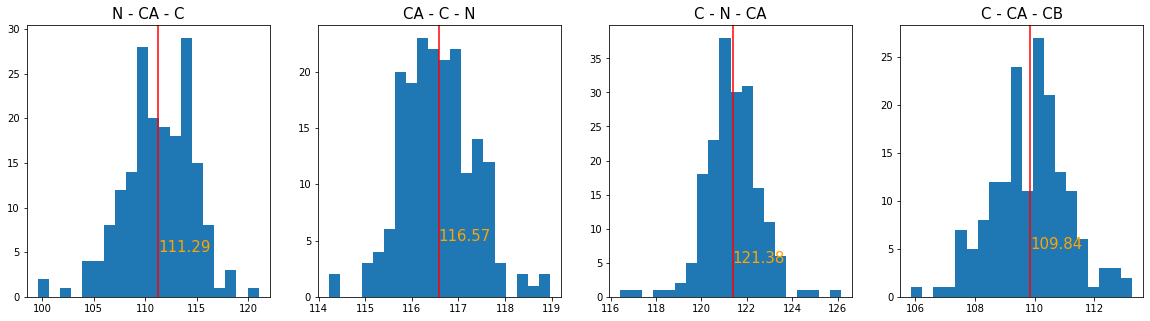

In [45]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))

for i, a in enumerate([('N', 'CA', 'C'), ('CA', 'C', 'N'), ('C', 'N', 'CA'), ('C', 'CA', 'CB')]):
    angles = compute_angles(coords, a)
    ax[i].hist(angles, bins=20)
    ax[i].axvline(np.mean(angles), c='red')
    ax[i].text(np.mean(angles), 5, f'{round(np.mean(angles), 2)}', c='orange', fontsize=15)
    ax[i].set_title(f'{a[0]} - {a[1]} - {a[2]}', fontsize=15)

# Distributions using several proteins

In [4]:
def get_dist_angle_distributions(domain, dist_angle_list):
    try:
        coords = get_coords(domain)
    except:
        print(domain, 'Fuck it')
        return
    
    if coords is None:
        return
    # distances
    # N-CA, CA-CB, CA-C, C-N, CA-CA
    
    it = 0
    for (at1, at2) in [('N', 'CA'), ('CA', 'CB'), ('CA', 'C'), ('C', 'N'), ('CA', 'CA')]:
        dist = list(compute_dist(coords, at1, at2))
        dist_angle_list[it].extend(dist)
        it += 1
        
    # angles
    # N-CA-C, CA-C-N, C-N-CA
    for angle in [('N', 'CA', 'C'), ('CA', 'C', 'N'), ('C', 'N', 'CA'), ('C', 'CA', 'CB')]:
        ang = list(compute_angles(coords, angle))
        dist_angle_list[it].extend(ang)
        it += 1
        
    return dist_angle_list

In [5]:
# train set domains
train_domains = np.loadtxt('../../data/our_input/train_domains.csv', dtype='O')

In [6]:
dist_angle = [[], [], [], [], [], [], [], [], []]
dist_angle

np.random.seed(1618)
train_domains = np.random.permutation(train_domains)
for i in range(50):
    dalist = get_dist_angle_distributions(train_domains[i], dist_angle)
    if dalist is None:
        pass
    else:
        dist_angle = dalist

/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8343.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8387.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain a is discontinuous at line 8445.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain b is discontinuous at line 8473.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8501.
  warnings.warn(
/home/tomasla/miniconda3/envs/dssp/lib/python3.8/site-packages/Bio/PDB/Structure

IndexError: string index out of range

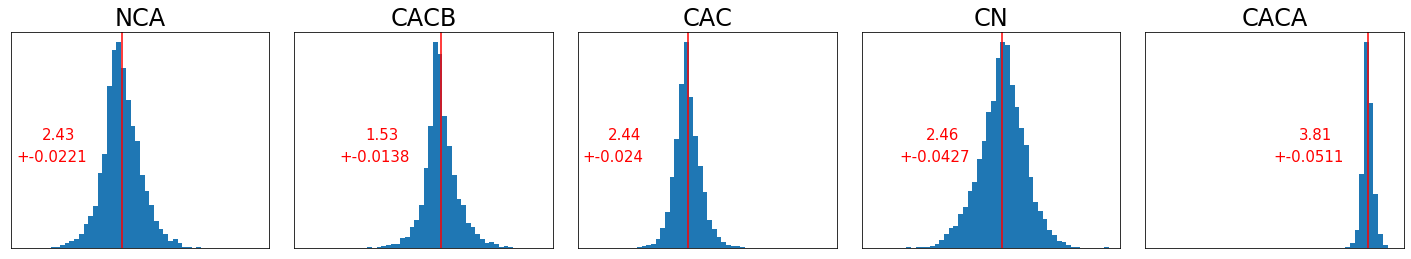

In [29]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for i, atoms in enumerate(['NCA', 'CACB', 'CAC', 'CN', 'CACA']):
    ax[i].hist(dist_angle[i], bins = 50)
    ax[i].axvline(np.mean(dist_angle[i]), c='red')
    ax[i].text(-0.3 + (np.mean(dist_angle[i]) -  np.min(dist_angle[i]))/ (np.max(dist_angle[i]) - np.min(dist_angle[i])), 0.5, f'{round(np.mean(dist_angle[i]), 2)}', c='red', fontsize=15, transform=ax[i].transAxes)
    ax[i].text(-0.4 + (np.mean(dist_angle[i]) -  np.min(dist_angle[i]))/ (np.max(dist_angle[i]) - np.min(dist_angle[i])), 0.4, f'+-{round(np.std(dist_angle[i]), 4)}', c='red', fontsize=15, transform=ax[i].transAxes)
    #ax[i].text(np.mean(dist_angle[i]), 0, f'{round(np.mean(dist_angle[i]), 2)}', c='red', fontsize=25)
    ax[i].set_title(f'{atoms}')
    #ax[i].set_xlim(1, 5)
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
fig.tight_layout()


plt.savefig('../../plots/structure_realization/inter_atom_distances.png', dpi = 200)

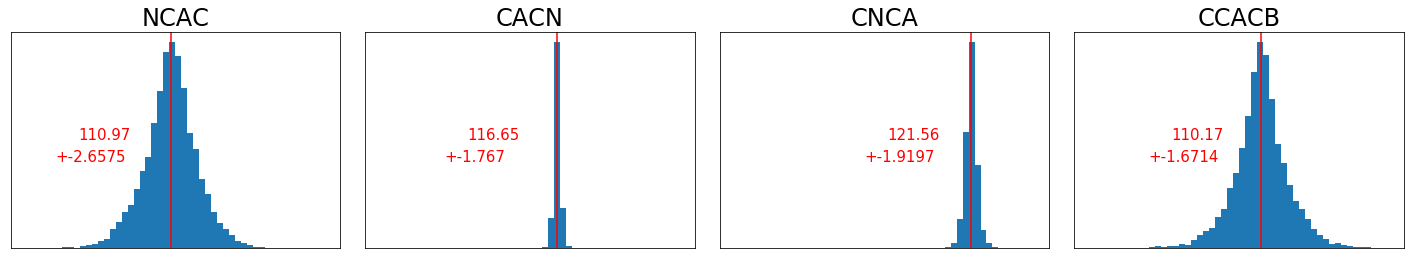

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for i, atoms in enumerate(['NCAC', 'CACN', 'CNCA', 'CCACB']):
    ax[i].hist(dist_angle[5 + i], bins = 50)
    ax[i].axvline(np.mean(dist_angle[i + 5]), c='red')
    #if atoms == 'CNCA':
    #    ax[i].text(0.14 + (np.mean(dist_angle[i + 5]) -  np.min(dist_angle[i + 5]))/ (np.max(dist_angle[i + 5]) - np.min(dist_angle[i + 5])), 0.5, f'{round(np.mean(dist_angle[i + 5]), 2)}', c='red', fontsize=15, transform=ax[i].transAxes)
    #    ax[i].text(0.08 + (np.mean(dist_angle[i + 5]) -  np.min(dist_angle[i + 5]))/ (np.max(dist_angle[i + 5]) - np.min(dist_angle[i + 5])), 0.4, f'+-{round(np.std(dist_angle[i + 5]), 4)}', c='red', fontsize=15, transform=ax[i].transAxes)
    #else:
    ax[i].text(-0.28 + (np.mean(dist_angle[i + 5]) -  np.min(dist_angle[i + 5]))/ (np.max(dist_angle[i + 5]) - np.min(dist_angle[i + 5])), 0.5, f'{round(np.mean(dist_angle[i + 5]), 2)}', c='red', fontsize=15, transform=ax[i].transAxes)
    ax[i].text(-0.35 + (np.mean(dist_angle[i + 5]) -  np.min(dist_angle[i + 5]))/ (np.max(dist_angle[i + 5]) - np.min(dist_angle[i + 5])), 0.4, f'+-{round(np.std(dist_angle[i + 5]), 4)}', c='red', fontsize=15, transform=ax[i].transAxes)
    #ax[i].text(np.mean(dist_angle[i]), 0, f'{round(np.mean(dist_angle[i]), 2)}', c='red', fontsize=25)
    ax[i].set_title(f'{atoms}')
    #ax[i].set_xlim(1, 5)
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('../../plots/structure_realization/inter_atom_angles.png', dpi = 200)